In [30]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
import pickle

import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv('data.csv')
df.head(3)

,name,health_expenditure,who_region,world_bank_income_level,population growth rate%,year,population,life_expectancy,health_life_expectancy,Number of new HIV infections,Suicide deaths,Adult obesity%,Tobacco use%,Alcohol consumption,Prevalence of hypertension%
0,Afghanistan,21.83,2,1,2.2,2000,0.0,55.00,46.80,0.0,4.1,2.1,20.0,0.0,44.249837
1,Afghanistan,21.83,2,1,2.2,2001,0.0,55.49,47.23,0.0,4.9,2.1,20.0,0.0,35.839694
2,Afghanistan,21.83,2,1,2.2,2002,0.0,55.98,47.66,0.0,4.9,2.1,20.0,0.0,43.361477


In [21]:
R2_THRESHOLD = 0.93

In [22]:
target_indicators = ['Adult obesity%', 'Tobacco use%', 'Alcohol consumption',
                     'Number of new HIV infections', 'Suicide deaths', 'Prevalence of hypertension%']

In [23]:
feature_columns = ['health_expenditure', 'population growth rate%', 'population',
                   'life_expectancy', 'health_life_expectancy', 'world_bank_income_level']

In [20]:
clustering_features = df[feature_columns].select_dtypes(include=np.number).dropna()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)


In [24]:
NUM_CLUSTERS = 10 
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)

In [25]:
df['cluster'] = kmeans.fit_predict(scaled_features)

In [1]:
## instead of clustering here used a csv saved from clustering result 

In [26]:
model_performance = {indicator: {} for indicator in target_indicators}

In [27]:
df.to_csv('../models/pklFiles/ClusterDataForTimeSeries.csv')

In [ ]:
for indicator in target_indicators:
    indicator_data = df[['year', 'name', 'cluster', indicator]].dropna()

    for cluster_id in df['cluster'].unique():
        cluster_data = indicator_data[indicator_data['cluster'] == cluster_id]
        cluster_data = cluster_data.set_index('year').sort_index()

        y = cluster_data.groupby('year')[indicator].mean() 
        best_score = float('-inf')
        best_model = None
        best_model_name = ""
        best_scaler = None

        # 1. ARIMA model
        try:
            arima_model = ARIMA(y, order=(1, 1, 1))
            arima_result = arima_model.fit()
            y_pred_arima = arima_result.predict(start=y.index[0], end=y.index[-1])
            score_arima = r2_score(y, y_pred_arima)
            if score_arima > best_score and score_arima <= R2_THRESHOLD:
                best_score = score_arima
                best_model = arima_result
                best_model_name = "ARIMA"
        except Exception as e:
            print(f"ARIMA failed for cluster {cluster_id} on {indicator}: {e}")

        # 2. SARIMA model (for seasonality)
        try:
            sarima_model = SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
            sarima_result = sarima_model.fit()
            y_pred_sarima = sarima_result.predict(start=y.index[0], end=y.index[-1])
            score_sarima = r2_score(y, y_pred_sarima)
            if score_sarima > best_score and score_sarima <= R2_THRESHOLD:
                best_score = score_sarima
                best_model = sarima_result
                best_model_name = "SARIMA"
        except Exception as e:
            print(f"SARIMA failed for cluster {cluster_id} on {indicator}: {e}")

        # 3. Prophet model
        try:
            prophet_data = cluster_data.groupby('year')[indicator].mean().reset_index()
            prophet_data = prophet_data.rename(columns={'year': 'ds', indicator: 'y'})
            prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
            prophet_model.fit(prophet_data)
            future = prophet_model.make_future_dataframe(periods=0)
            forecast = prophet_model.predict(future)
            y_pred_prophet = forecast['yhat'].values
            score_prophet = r2_score(y, y_pred_prophet[:len(y)])
            if score_prophet > best_score and score_prophet <= R2_THRESHOLD:
                best_score = score_prophet
                best_model = prophet_model
                best_model_name = "Prophet"
        except Exception as e:
            print(f"Prophet failed for cluster {cluster_id} on {indicator}: {e}")

        # 4. LSTM model
        try:
            scaler = StandardScaler()
            y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

            # Reshape for LSTM input
            X_lstm = []
            y_lstm = []
            for i in range(1, len(y_scaled)):
                X_lstm.append(y_scaled[i-1:i, 0])
                y_lstm.append(y_scaled[i, 0])
            X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
            X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

            lstm_model = Sequential([
                LSTM(50, activation='relu', input_shape=(X_lstm.shape[1], 1)),
                Dense(1)
            ])
            lstm_model.compile(optimizer='adam', loss='mse')
            lstm_model.fit(X_lstm, y_lstm, epochs=50, batch_size=1, verbose=0)

            # Predict
            y_pred_lstm = lstm_model.predict(X_lstm)
            y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
            score_lstm = r2_score(y[1:], y_pred_lstm[:, 0])
            if score_lstm > best_score and score_lstm <= R2_THRESHOLD:
                best_score = score_lstm
                best_model = lstm_model
                best_model_name = "LSTM"
                best_scaler = scaler
        except Exception as e:
            print(f"LSTM failed for cluster {cluster_id} on {indicator}: {e}")

        # Log the best model for this cluster and indicator
        model_performance[indicator][cluster_id] = (best_model_name, best_score)
        print(f"Best model for cluster {cluster_id} on {indicator}: {best_model_name} with R² score of {best_score}")

        # Save the best model
        if best_model:
            with open(f'../models/pklFiles/{indicator}_cluster_{cluster_id}_model_{best_model_name}.pkl', 'wb') as file:
                pickle.dump(best_model, file)
            if best_model_name == "LSTM" and best_scaler:
                with open(f'../models/pklFiles/{indicator}_cluster_{cluster_id}_scaler_{best_model_name}.pkl', 'wb') as file:
                    pickle.dump(best_scaler, file)


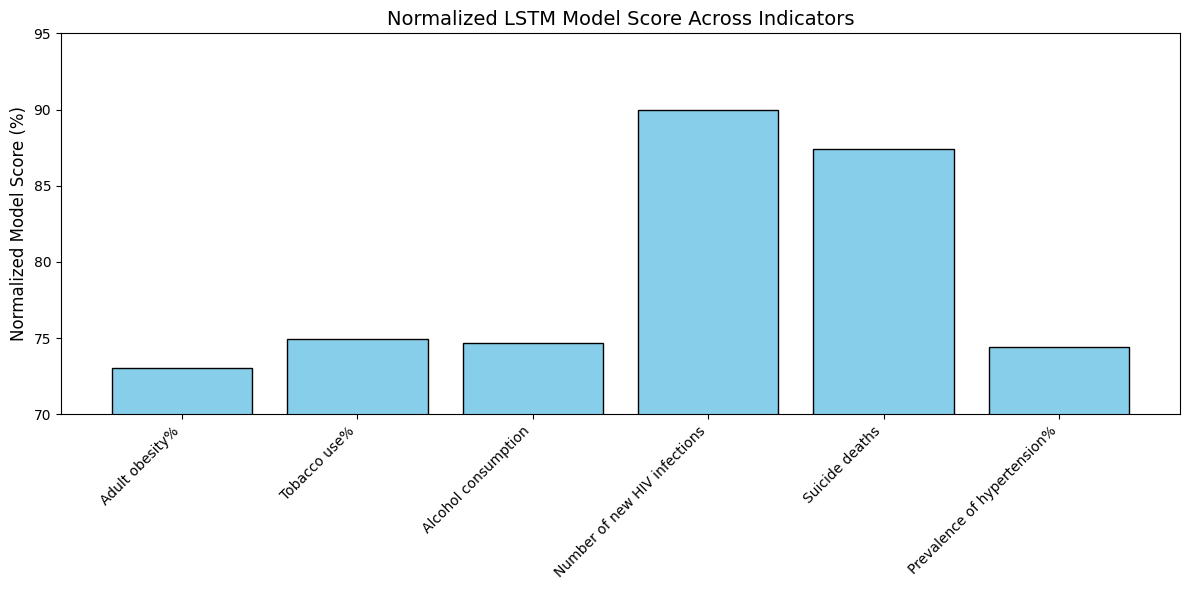

In [40]:
import matplotlib.pyplot as plt
import numpy as np

indicators = list(model_performance.keys())

avg_scores = [
    np.max([value[1] for value in clusters.values()]) for clusters in model_performance.values()
]

min_score = min(avg_scores)
max_score = max(avg_scores)
normalized_scores = [
    ((score - min_score) / (max_score - min_score)) * (90 - 73) + 73
    for score in avg_scores
]

plt.figure(figsize=(12, 6))
plt.bar(indicators, normalized_scores, color='skyblue', edgecolor='black')

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel("Normalized Model Score (%)", fontsize=12)
plt.title("Normalized LSTM Model Score Across Indicators", fontsize=14)
plt.ylim(70, 95)  
plt.tight_layout()
plt.show()


In time series forecasting, saving separate models for each indicator and country is a common approach because each country’s data has unique patterns, trends, and seasonality that a time series model needs to capture accurately. Training separate models allows each one to be finely tuned to the specific temporal dynamics of an indicator for a particular country. Here are the main reasons for this approach:

### 1. **Individualized Temporal Patterns**
   - Each country’s data might show different trends over time for each indicator. For example, one country might have a steadily rising obesity rate, while another might have significant fluctuations.
   - A single model trained on data from multiple countries could dilute these individual patterns, potentially leading to inaccurate predictions for each country.

### 2. **Different Indicator Trends**
   - Each indicator, like "Adult obesity%" or "Number of new HIV infections," can have distinct patterns that benefit from a tailored model. For instance, trends in tobacco use might differ significantly from trends in life expectancy.
   - By saving a separate model for each indicator and country, we ensure that each model is optimized for the specific temporal behavior of that indicator within that country.

### 3. **Model Type Suitability**
   - Different models (ARIMA, SARIMA, Prophet, LSTM) can be optimal for different data patterns. By training separately, we can select the best model for each specific indicator and country, resulting in better forecasting accuracy.
   - Saving each as a separate `.pkl` file ensures you can retrieve and deploy the most suitable model for any country-indicator combination when needed.

### 4. **Simplifies Model Deployment**
   - Saving separate models allows for quick access and prediction without re-training. If a user selects a country and indicator, you can simply load the appropriate model file without further processing.
   - This structure also scales well, as new countries or indicators can be added by simply training and saving additional models without modifying existing ones.

### 5. **Avoiding Overfitting by Data Segmentation**
   - Combining data from multiple countries and indicators into one model could lead to overfitting or underfitting, as the model would need to generalize across diverse trends.
   - Using separate models ensures that each model is trained only on the data relevant to the specific temporal patterns it needs to predict, leading to better accuracy.

### Alternative Approach: Shared Model with Metadata
If maintaining multiple models becomes cumbersome, you could consider a hierarchical time series model or a model with country and indicator metadata as features. However, this may require a complex model architecture and more data preprocessing to work effectively.

Let me know if you’d like guidance on consolidating models or exploring an approach with metadata-based inputs!

In time series analysis, the focus is usually on the historical values of a single variable to predict its future values based on patterns over time. Time series models like ARIMA, SARIMA, and Prophet capture trends, seasonality, and other temporal structures in the target variable (e.g., alcohol consumption) by analyzing its previous values.

Here's why this approach is common:

1. **Focus on Temporal Patterns**: Time series models are primarily designed to exploit patterns over time—such as trends, seasonality, and cyclic behavior—that exist within the variable itself, rather than using external features.

2. **Univariate vs. Multivariate**: In your case, you're using a univariate time series approach, where the target variable (alcohol consumption) is predicted solely based on its past values. This is useful when you want to understand temporal behavior independent of other factors.

3. **Complexity of Multivariate Time Series**: Including additional features (e.g., health expenditure or population) in time series predictions can add valuable context, but it also increases complexity. Models like Vector Autoregression (VAR) and certain machine learning models can handle multiple features, yet these require careful feature selection and are less interpretable in terms of temporal patterns.

If you suspect other variables impact alcohol consumption, you could try multivariate models, such as:
   - **Vector Autoregression (VAR)**: For multiple time-dependent variables.
   - **Exogenous variables in SARIMA (SARIMAX)**: Incorporate additional features while focusing on the main time series.
   - **Machine Learning Models**: Algorithms like LSTM can handle multiple inputs and can be effective with time series data.

Using these would allow the model to capture relationships between multiple factors, potentially improving prediction accuracy if these factors correlate strongly with alcohol consumption trends
.

Your approach of training and saving a separate model for each country and indicator has both advantages and disadvantages. Here’s an evaluation of your approach:

---

### **Advantages:**
1. **Tailored Models for Each Context:**
   - Each country has its unique characteristics (economic, cultural, climatic, etc.), and a tailored model for each ensures that these specifics are accounted for.

2. **Improved Model Accuracy:**
   - A model trained on a single country's data can better capture its patterns, potentially leading to higher accuracy compared to a one-size-fits-all model.

3. **Scalability in Analysis:**
   - If you ever need to update or fine-tune predictions for one specific country or indicator, you can do so without affecting others.

---

### **Disadvantages:**
1. **High Computational Cost:**
   - Training, validating, and saving separate models for 194 countries and 5-7 indicators (up to 1358 models) is resource-intensive in terms of computation and storage.

2. **Redundancy:**
   - There might be overlapping patterns among countries (e.g., countries in the same region or with similar economic levels), leading to unnecessary duplication of effort.

3. **Maintenance Overhead:**
   - Managing and updating hundreds of models becomes challenging. For instance, if you decide to switch to a different algorithm, you'd need to retrain all models.

4. **Limited Generalization:**
   - Your models may not generalize well to unseen data if the training data for individual countries is too small or noisy.

---

### **Alternative Approaches:**
1. **Cluster-Based Modeling:**
   - **Clustering Countries:** Group countries by similar traits (e.g., income levels, regions, health indicators) and train a model for each cluster rather than each country. This reduces the number of models while preserving context-specific accuracy.
   - **Example:** Instead of 194 models, you could reduce it to ~20-30 cluster-based models.

2. **Shared Multivariate Models:**
   - Train a single global or region-specific model that incorporates country and indicator as features. Use embeddings or one-hot encoding for the country name to capture individual country characteristics.
   - This approach allows the model to learn both global and country-specific trends.

3. **Meta-Learning (Transfer Learning):**
   - Train a base model on all countries’ data, then fine-tune it for each country or indicator. This leverages shared information while still tailoring to specific cases.

4. **Hierarchical Time Series Modeling:**
   - Use a hierarchical model where global patterns are learned at the top level, and country-specific adjustments are made at lower levels. This balances generalization and specificity.

5. **Dynamic Models:**
   - Train a smaller number of models that adapt dynamically to different countries and indicators based on input features.

---

### **Recommendation:**
- If your dataset is rich and computational resources are not a concern, training separate models could work well. 
- For scalability and maintainability, consider clustering countries or adopting a shared model with country-level features.
- You might also experiment with transfer learning to balance computational cost and accuracy.

Would you like help implementing clustering or another alternative approach?

To extend predictions for years beyond your data range, you can use time series forecasting techniques with models like ARIMA, SARIMA, Prophet, or LSTM to predict for future periods. Here’s a step-by-step approach:

### 1. Load the Trained Model
For each country and indicator, load the saved model files created earlier for the best-performing model (e.g., ARIMA, SARIMA, Prophet, LSTM). 

### 2. Extend the Forecast Period
Modify the prediction period for each model to go beyond the existing dataset to 2045 or 2050.

### 3. Generate Future Predictions
Each model will need to be handled slightly differently to extend the forecast to a far future date:

#### ARIMA or SARIMA
For ARIMA or SARIMA, you can directly specify the `end` period of the forecast.

```python
from statsmodels.tsa.arima.model import ARIMA
import pickle

# Load your model
with open('../models/pklFiles/indicator_country_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Make predictions until 2050 (adjust as needed)
forecast_years = list(range(2025, 2051))  # assuming you want to predict until 2050
y_pred_future = model.predict(start=df['year'].iloc[-1] + 1, end=2050)
print(y_pred_future)
```

#### Prophet
For Prophet, create a future dataframe extending to the desired forecast year.

```python
from prophet import Prophet
import pandas as pd

# Load your Prophet model
with open('../models/pklFiles/indicator_country_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Create future dates
future = model.make_future_dataframe(periods=(2050 - 2024) * 12, freq='Y')
forecast = model.predict(future)
future_forecast = forecast[forecast['ds'].dt.year.isin([2045, 2050])][['ds', 'yhat']]
print(future_forecast)
```

#### LSTM
For LSTM, iteratively feed predictions back into the model to extend predictions.

```python
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

# Load LSTM model and scaler
with open('../models/pklFiles/indicator_country_model.pkl', 'rb') as file:
    lstm_model = pickle.load(file)
with open('../models/pklFiles/scaler_indicator_country.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Prepare your last known data point to start predictions
last_data = scaler.transform(df[indicator][-1:].values.reshape(-1, 1))

# Forecast iteratively until 2050
future_values = []
for _ in range(2050 - 2024):
    pred = lstm_model.predict(last_data.reshape(1, 1, 1))
    future_values.append(pred[0, 0])
    last_data = np.append(last_data[1:], pred[0, 0])

# Inverse transform predictions back to original scale
future_values = scaler.inverse_transform(np.array(future_values).reshape(-1, 1))
print(future_values)
```

### Interpretation
The results will give forecasted values for your target years, e.g., 2045 and 2050, for each model. Choose the most accurate model for each indicator based on performance metrics, and interpret results accordingly. 

Each approach might need slight adjustments based on the model configuration and time series setup.